In [1]:
# create a visualisation of vectordatabase
from dotenv import load_dotenv
import chromadb
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from langchain.embeddings import OpenAIEmbeddings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.colors import BoundaryNorm
from types import SimpleNamespace
from collections import Counter
from omegaconf import OmegaConf
from sklearn.decomposition import PCA

load_dotenv()

# Langchain-Chroma natively does not appear to return embeddings instead of documents, so extend the Chroma API to do so
from langchain.vectorstores import Chroma
def extend_chroma(cls):
    def raw_similarity_search_with_score(self, query, k=4, filter=None, **kwargs):
        if self._embedding_function is None:
            # accessing private attribute ...
            results = self._Chroma__query_collection(
                query_texts=[query], n_results=k, where=filter
            )
        else:
            query_embedding = self._embedding_function.embed_query(query)
            results = self._Chroma__query_collection(
                query_embeddings=[query_embedding], n_results=k, where=filter
            )
        return results
    
    setattr(cls, 'raw_similarity_search_with_score', raw_similarity_search_with_score)
    return cls

Chroma = extend_chroma(Chroma)


def get_all_index_paths(base_path, entity):
    if entity is not None:
        return [path for subpath in Path(base_path).iterdir() if subpath.is_dir() for path in subpath.iterdir() if path.is_dir() and entity in str(path)]
    else:
        return [path for subpath in Path(base_path).iterdir() if subpath.is_dir() for path in subpath.iterdir() if path.is_dir()]


def get_all_sources(path, entity=None):
    paths = get_all_index_paths(path, entity="_500_100")
    embd_store = {}
    for idx_path in paths:
        embd_store[f"{idx_path.parent.name}_{idx_path.name}"] = load_embeddings(idx_path)
    return embd_store


def load_embeddings(index_path):
    embeddings = OpenAIEmbeddings()
    client_settings = chromadb.config.Settings(
        chroma_db_impl="duckdb+parquet",
        persist_directory=str(index_path),
        anonymized_telemetry=False
    )
    vectorstore = Chroma(persist_directory=index_path, embedding_function=embeddings, client_settings=client_settings)
    data = vectorstore._collection.get(include=["embeddings", "documents", "metadatas"])
    return SimpleNamespace(data=data, vectorstore=vectorstore)


def get_all_query_doc_ids(embd_store, all_queries, search_depth=25):
    query_to_ids = defaultdict(dict)
    for entity, topics in all_queries.items():
        per_entity = {}
        for topic in topics:
            ids = []
            for vs_name, vs_data in embd_store.items():
                if entity in vs_name:
                    vs_store = getattr(vs_data, "vectorstore")
                    embeds = vs_store.raw_similarity_search_with_score(topic, k=search_depth)["ids"][0]
                    ids.extend(embeds)
            per_entity[topic] = pd.Series(ids)
        query_to_ids[entity] = per_entity
    return query_to_ids


def prepare_data(embd_store):
    all_ids = []
    all_embeddings = []
    for doc_id, data in embd_store.items():
        _data = getattr(data, "data")
        all_ids.extend(_data["ids"])
        all_embeddings.extend(_data["embeddings"])
    # convert all_ids to a dataframe column, spread all embeddings also to the dataframe with shape 0 as rows and shape 1 as columns
    df = pd.DataFrame(all_embeddings, index=all_ids)
    return df   


def transform_tsne(embeddings_df, scale_features=True, apply_pca=True, n_components=2, init="pca"):
    np_data = embeddings_df.to_numpy()
    if scale_features:
        np_data = StandardScaler().fit_transform(np_data)
    if apply_pca: 
        pca = PCA(n_components=200)
        np_data = pca.fit_transform(np_data)
    tsne = TSNE(
        n_components=n_components,
        init=init,
        perplexity=30, #early_exaggeration=12, learning_rate=200,   
        random_state=123
        )
    data_transformed = tsne.fit_transform(np_data)
    return embeddings_df, data_transformed


def visualize_tsne(ax, embeddings_df, data_transformed, query_name, query_ids):
    transformed_df = pd.DataFrame(data_transformed, index=embeddings_df.index)
    transformed_df.rename(columns={0: "dim0", 1: "dim1"}, inplace=True)
    df = pd.merge(embeddings_df, transformed_df, left_index=True, right_index=True)
    df["sim_searched"] = df.index.isin(query_ids)
    lab_enc = LabelEncoder()
    labels_encoded = lab_enc.fit_transform(df["sim_searched"])
    cmap = {0: "grey", 1: "green"}
    colors = [cmap.get(label, "grey") for label in labels_encoded]
    alphas = np.where(labels_encoded == 0, 0.05, 0.9)
    scatter = ax.scatter(df.loc[:, "dim0"], df.loc[:, "dim1"], c=colors, s=3, alpha=alphas) 
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_title(query_name, fontweight='bold', fontsize=6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    


In [2]:
# create a cluster per document per query

path = "/mnt/bulk/dferber/catchy/LLM_Vector/Vector_LLM_for_Medical_QA/chroma_db"

crc_onfig = OmegaConf.load("/mnt/bulk/dferber/catchy/LLM_Vector/Vector_LLM_for_Medical_QA/conf/mCRC_config.yaml")
paca_config = OmegaConf.load("/mnt/bulk/dferber/catchy/LLM_Vector/Vector_LLM_for_Medical_QA/conf/pancreatic_config.yaml")
hcc_config = OmegaConf.load("/mnt/bulk/dferber/catchy/LLM_Vector/Vector_LLM_for_Medical_QA/conf/hcc_config.yaml")

embd_store = get_all_sources(path, entity="_500_100")

hcc_topics = hcc_config.topics
mCRC_topics = crc_onfig.topics
paca_topics = paca_config.topics

all_queries = {"HCC": hcc_topics, "mCRC": mCRC_topics, "PancreaticCancer": paca_topics}
all_query_ids = get_all_query_doc_ids(embd_store, all_queries, search_depth=25)

embeddings_df = prepare_data(embd_store)
embeddings_df, data_transformed = transform_tsne(embeddings_df)

hcc_queries = all_query_ids["HCC"]
mcrc_queries = all_query_ids["mCRC"]
paca_queries = all_query_ids["PancreaticCancer"]


Unable to connect optimized C data functions [No module named '_testbuffer'], falling back to pure Python


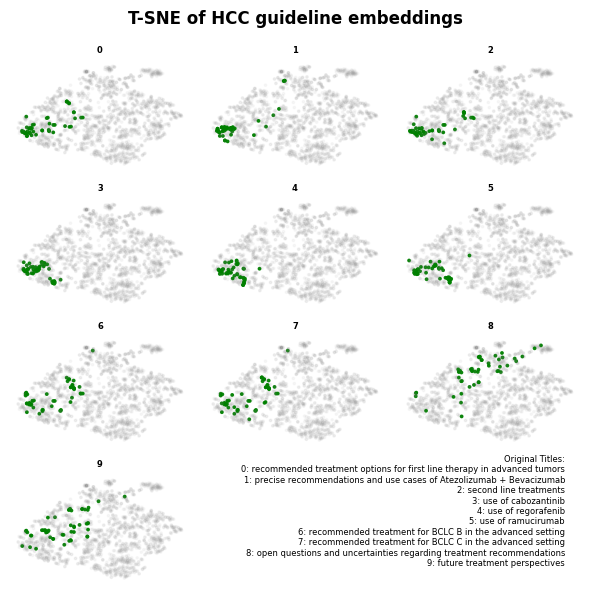

In [42]:
# HCC
hcc_queries = all_query_ids["HCC"]
n = len(hcc_queries)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axes = plt.subplots(rows, cols, figsize=(6,6))
if rows > 1 and cols > 1:
    axes = axes.flatten()

fig.suptitle("T-SNE of HCC guideline embeddings", fontsize=12, fontweight='bold')
idx_to_query = {}
for i, (ax, query) in enumerate(zip(axes, hcc_queries.items())):
    key, ids = query
    idx_to_query[i] = key
    visualize_tsne(ax, embeddings_df, data_transformed, query_name=i, query_ids=ids)

for i in range(len(hcc_queries), rows * cols):
    fig.delaxes(axes[i])

original_titles_text = "Original Titles:\n" + "\n".join([f"{i}: {query}" for i, query in idx_to_query.items()])
fig.text(0.95, 0.05, original_titles_text, fontsize=6, ha='right', va='bottom')

plt.tight_layout()
plt.show()
fig.savefig("Figures/tsne_hcc_embeddings_refactored.png", dpi=500) 

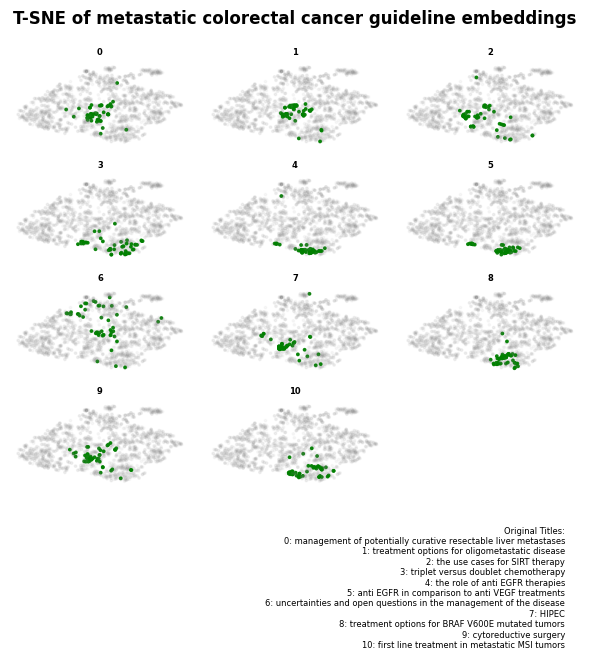

In [43]:
# mCRC
mcrc_queries = all_query_ids["mCRC"]
n = len(mcrc_queries)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))
n = len(mcrc_queries)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axes = plt.subplots(rows, cols, figsize=(6,5))
if rows > 1 and cols > 1:
    axes = axes.flatten()

fig.suptitle("T-SNE of metastatic colorectal cancer guideline embeddings", fontsize=12, fontweight='bold')
idx_to_query = {}
for i, (ax, query) in enumerate(zip(axes, mcrc_queries.items())):
    key, ids = query
    idx_to_query[i] = key
    visualize_tsne(ax, embeddings_df, data_transformed, query_name=i, query_ids=ids)

for i in range(len(mcrc_queries), rows * cols):
    fig.delaxes(axes[i])

original_titles_text = "Original Titles:\n" + "\n".join([f"{i}: {query}" for i, query in idx_to_query.items()])
# add the text directly under the figure
fig.text(0.95, -0.3, original_titles_text, fontsize=6, ha='right', va='bottom')

plt.tight_layout()
plt.show()
fig.savefig("Figures/tsne_mCRC_embeddings.png", dpi=500, bbox_inches='tight')

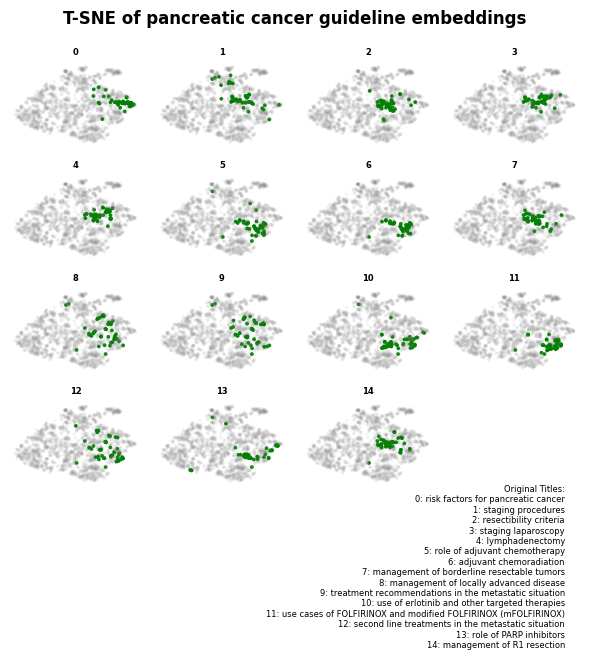

In [44]:
# pancreatic cancer
paca_queries = all_query_ids["PancreaticCancer"]
n = len(paca_queries)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axes = plt.subplots(rows, cols, figsize=(6,5))
if rows > 1 and cols > 1:
    axes = axes.flatten()

fig.suptitle("T-SNE of pancreatic cancer guideline embeddings", fontsize=12, fontweight='bold')
idx_to_query = {}
for i, (ax, query) in enumerate(zip(axes, paca_queries.items())):
    key, ids = query
    idx_to_query[i] = key
    visualize_tsne(ax, embeddings_df, data_transformed, query_name=i, query_ids=ids)

for i in range(len(paca_queries), rows * cols):
    fig.delaxes(axes[i])

original_titles_text = "Original Titles:\n" + "\n".join([f"{i}: {query}" for i, query in idx_to_query.items()])
# add the text directly under the figure
fig.text(0.95, -0.3, original_titles_text, fontsize=6, ha='right', va='bottom')

plt.tight_layout()
plt.show()
fig.savefig("Figures/tsne_pancreaticcancer_embeddings.png", dpi=500, bbox_inches='tight')

In [32]:
# create 1 plot per query and save

def visualize_one_tsne(embeddings_df, data_transformed, query_ids):
    fig, ax = plt.subplots(figsize=(2,2))
    transformed_df = pd.DataFrame(data_transformed, index=embeddings_df.index)
    transformed_df.rename(columns={0: "dim0", 1: "dim1"}, inplace=True)
    df = pd.merge(embeddings_df, transformed_df, left_index=True, right_index=True)
    df["sim_searched"] = df.index.isin(query_ids)
    lab_enc = LabelEncoder()
    labels_encoded = lab_enc.fit_transform(df["sim_searched"])
    cmap = {0: "grey", 1: "green"}
    colors = [cmap.get(label, "grey") for label in labels_encoded]
    alphas = np.where(labels_encoded == 0, 0.05, 0.9)
    scatter = ax.scatter(df.loc[:, "dim0"], df.loc[:, "dim1"], c=colors, s=3, alpha=alphas) 
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    # ax.set_title(query_name, fontweight='bold', fontsize=6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    return fig

In [ ]:
# HCC
hcc_queries = all_query_ids["HCC"]

for i, (key, ids) in enumerate(hcc_queries.items()):
    fig = visualize_one_tsne(embeddings_df, data_transformed, query_name=i, query_ids=ids)
    fig.savefig(f"Figures/tSNE/tSNE_per_query/tsne_hcc_embeddings_{key}.png", dpi=500)

In [ ]:
mcrc_queries = all_query_ids["mCRC"]

for i, (key, ids) in enumerate(mcrc_queries.items()):
    fig = visualize_one_tsne(embeddings_df, data_transformed, query_name=i, query_ids=ids)
    fig.savefig(f"Figures/tSNE/tSNE_per_query/tsne_mcrc_embeddings_{key}.png", dpi=500)

In [ ]:
paca_queries = all_query_ids["PancreaticCancer"]

for i, (key, ids) in enumerate(paca_queries.items()):
    fig = visualize_one_tsne(embeddings_df, data_transformed, query_name=i, query_ids=ids)
    fig.savefig(f"Figures/tSNE/tSNE_per_query/tsne_pancreaticcancer_embeddings_{key}.png", dpi=500)

In [46]:
# calculate in document cos sim

df = prepare_data(embd_store)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
01e23f60-471d-11ee-8a0f-00e04c950b44,-0.021671,-0.009073,0.011391,-0.032674,-0.007575,0.016001,-0.014025,0.011617,-0.028361,0.007258,...,0.012598,0.009111,0.003085,-0.012521,-0.026282,-0.001347,-0.019346,-0.008110,-0.028774,-0.002297
01e23b8c-471d-11ee-8a0f-00e04c950b44,-0.010241,-0.007314,0.030138,-0.041378,-0.008287,0.028269,-0.037510,0.007749,-0.033435,0.010825,...,0.023583,-0.005909,-0.005912,-0.032422,-0.014199,-0.036939,-0.027698,-0.015939,0.004711,-0.004630
01e23be6-471d-11ee-8a0f-00e04c950b44,-0.007556,-0.019844,0.025308,-0.015099,-0.017192,0.035263,-0.003050,0.003173,-0.023042,0.004338,...,0.011348,-0.008583,0.013967,-0.019577,-0.043393,-0.005664,-0.026467,-0.010422,-0.016579,-0.013700
01e23c40-471d-11ee-8a0f-00e04c950b44,0.015889,-0.005652,0.011069,-0.029150,-0.004351,0.023411,-0.037866,-0.026093,-0.036471,-0.009795,...,0.028131,0.006818,0.017270,-0.014414,-0.041271,-0.006386,-0.011303,-0.020408,-0.002911,-0.026871
01e23c9a-471d-11ee-8a0f-00e04c950b44,-0.017601,-0.016795,0.018156,-0.019240,0.009990,0.030604,-0.013036,-0.009845,-0.014152,0.006977,...,0.018315,0.001146,-0.001029,-0.028595,-0.030551,-0.017311,-0.026309,0.000714,-0.025358,-0.013373


In [145]:
hcc_queries = all_query_ids["HCC"]
mcrc_queries = all_query_ids["mCRC"]
paca_queries = all_query_ids["PancreaticCancer"]

In [150]:
def cosine_similarity(A, B):
    dot_product = np.dot(A, B.T)
    magnitude_A = np.linalg.norm(A, axis=1)
    magnitude_B = np.linalg.norm(B, axis=1)
    return dot_product / (magnitude_A[:, np.newaxis] * magnitude_B[np.newaxis, :])


# HCC
hcc_cosine_similarities = {}
for key, query in hcc_queries.items():   
    hcc_embeddings = df[df.index.isin(query)]
    hcc_embeddings = hcc_embeddings.to_numpy()
    cos_sim = cosine_similarity(hcc_embeddings, hcc_embeddings)
    cos_sim = cos_sim.mean()
    hcc_cosine_similarities[key] = cos_sim

# mCRC
mcrc_cosine_similarities = {}
for key, query in mcrc_queries.items():   
    mcrc_embeddings = df[df.index.isin(query)]
    mcrc_embeddings = mcrc_embeddings.to_numpy()
    cos_sim = cosine_similarity(mcrc_embeddings, mcrc_embeddings)
    cos_sim = cos_sim.mean()
    mcrc_cosine_similarities[key] = cos_sim

# PancreaticCancer
paca_cosine_similarities = {}
for key, query in paca_queries.items():   
    paca_embeddings = df[df.index.isin(query)]
    paca_embeddings = paca_embeddings.to_numpy()
    cos_sim = cosine_similarity(paca_embeddings, paca_embeddings)
    cos_sim = cos_sim.mean()
    paca_cosine_similarities[key] = cos_sim

In [151]:
hcc_cosine_similarities

{'recommended treatment options for first line therapy in advanced tumors': 0.8572443525586994,
 'precise recommendations and use cases of Atezolizumab + Bevacizumab': 0.8599631901119945,
 'second line treatments': 0.8524509388058694,
 'use of cabozantinib': 0.8654540260142992,
 'use of regorafenib': 0.865308793597403,
 'use of ramucirumab': 0.8591352030360029,
 'recommended treatment for BCLC B in the advanced setting': 0.8485778372722832,
 'recommended treatment for BCLC C in the advanced setting': 0.8521769177388003,
 'open questions and uncertainties regarding treatment recommendations': 0.813663301929728,
 'future treatment perspectives': 0.8242718500045908}

In [152]:
mcrc_cosine_similarities

{'management of potentially curative resectable liver metastases': 0.8533791933174448,
 'treatment options for oligometastatic disease': 0.8457258887006683,
 'the use cases for SIRT therapy': 0.8327379873904731,
 'triplet versus doublet chemotherapy': 0.8569851495281342,
 'the role of anti EGFR therapies': 0.868408724074368,
 'anti EGFR in comparison to anti VEGF treatments': 0.8649057328194065,
 'uncertainties and open questions in the management of the disease': 0.8122757771078692,
 'HIPEC': 0.8499685828856253,
 'treatment options for BRAF V600E mutated tumors': 0.8700785086125062,
 'cytoreductive surgery': 0.8483599317252049,
 'first line treatment in metastatic MSI tumors': 0.8660105244976206}

In [153]:
paca_cosine_similarities

{'risk factors for pancreatic cancer': 0.8468733455184614,
 'staging procedures': 0.8203041466818726,
 'resectibility criteria': 0.8254411507070422,
 'staging laparoscopy': 0.8353408999962576,
 'lymphadenectomy': 0.8298873315925323,
 'role of adjuvant chemotherapy': 0.8544079629992947,
 'adjuvant chemoradiation': 0.8599077154961174,
 'management of borderline resectable tumors': 0.8333809039799925,
 'management of locally advanced disease': 0.8408764742882598,
 'treatment recommendations in the metastatic situation': 0.8397529192397344,
 'use of erlotinib and other targeted therapies': 0.8377339734925329,
 'use cases of FOLFIRINOX and modified FOLFIRINOX (mFOLFIRINOX)': 0.8661317991185666,
 'second line treatments in the metastatic situation': 0.8446110893317782,
 'role of PARP inhibitors': 0.8335282158580237,
 'management of R1 resection': 0.83408450535285}

In [154]:
hcc_cosim_df = pd.DataFrame(list(hcc_cosine_similarities.items()), columns=['Category', 'Value'])
mcrc_cosim_df = pd.DataFrame(list(mcrc_cosine_similarities.items()), columns=['Category', 'Value'])
paca_cosim_df = pd.DataFrame(list(paca_cosine_similarities.items()), columns=['Category', 'Value'])

hcc_cosim_df.set_index("Category", inplace=True)
mcrc_cosim_df.set_index("Category", inplace=True)
paca_cosim_df.set_index("Category", inplace=True)

In [163]:
def plot_horizontal_bar(df):
    df.sort_values(by="Value", inplace=True, ascending=False)
    fig, ax = plt.subplots(figsize=(6,3))
    bars = ax.barh(df.index, df['Value'], log=True)

    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width:.2f}', 
                    xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(12, 0),  # 5 points horizontal offset
                    textcoords="offset points", size=10,
                    ha='center', va='center')
    
    # Remove x and y ticks and labels
    ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_xlabel('')
    #ax.set_ylabel('')
    ax.xaxis.set_label_text('')
    ax.xaxis.set_visible(False)
    #ax.yaxis.set_label_text('')
    #ax.set_title('Horizontal Bar Plot with Annotations and Log Scale')

    fig.show()

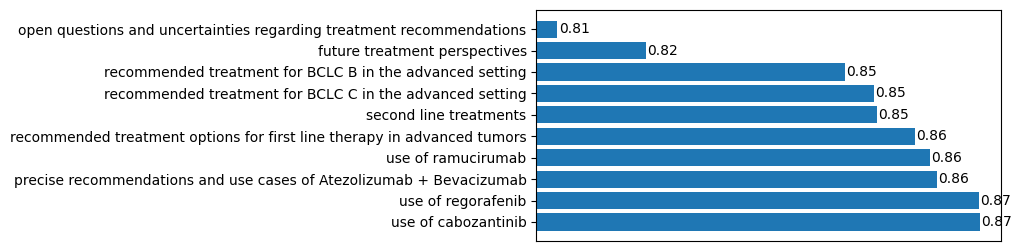

In [164]:
plot_horizontal_bar(hcc_cosim_df)

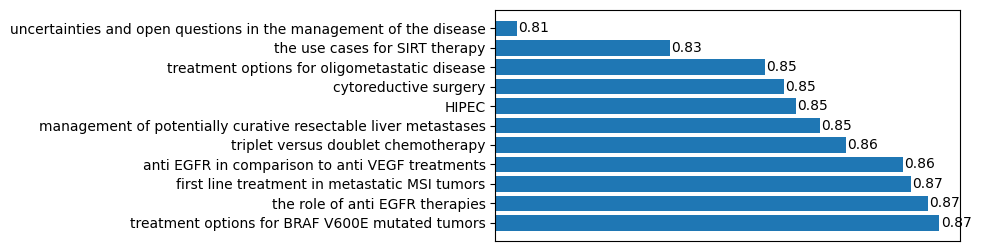

In [165]:
plot_horizontal_bar(mcrc_cosim_df)

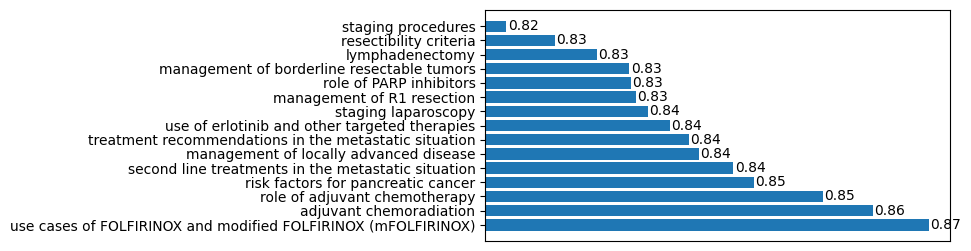

In [166]:
plot_horizontal_bar(paca_cosim_df)

In [ ]:
####################################################################################

In [2]:
# color highlight doc of origin
# create a visualisation of vectordatabase
from dotenv import load_dotenv
import chromadb
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from langchain.embeddings import OpenAIEmbeddings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.colors import BoundaryNorm
from types import SimpleNamespace
from collections import Counter
from omegaconf import OmegaConf
from sklearn.decomposition import PCA

load_dotenv()

# Langchain-Chroma natively does not appear to return embeddings instead of documents, so extend the Chroma API to do so
from langchain.vectorstores import Chroma
def extend_chroma(cls):
    def raw_similarity_search_with_score(self, query, k=4, filter=None, **kwargs):
        if self._embedding_function is None:
            # accessing private attribute ...
            results = self._Chroma__query_collection(
                query_texts=[query], n_results=k, where=filter
            )
        else:
            query_embedding = self._embedding_function.embed_query(query)
            results = self._Chroma__query_collection(
                query_embeddings=[query_embedding], n_results=k, where=filter
            )
        return results
    
    setattr(cls, 'raw_similarity_search_with_score', raw_similarity_search_with_score)
    return cls

Chroma = extend_chroma(Chroma)


def get_all_index_paths(base_path, entity):
    if entity is not None:
        return [path for subpath in Path(base_path).iterdir() if subpath.is_dir() for path in subpath.iterdir() if path.is_dir() and entity in str(path)]
    else:
        return [path for subpath in Path(base_path).iterdir() if subpath.is_dir() for path in subpath.iterdir() if path.is_dir()]


def load_embeddings(index_path):
    embeddings = OpenAIEmbeddings()
    client_settings = chromadb.config.Settings(
        chroma_db_impl="duckdb+parquet",
        persist_directory=str(index_path),
        anonymized_telemetry=False
    )
    vectorstore = Chroma(persist_directory=index_path, embedding_function=embeddings, client_settings=client_settings)
    data = vectorstore._collection.get(include=["embeddings", "documents", "metadatas"])
    return SimpleNamespace(data=data, vectorstore=vectorstore)


def get_all_sources(path, entity=None):
    paths = get_all_index_paths(path, entity="_500_100")
    embd_store = {}
    for idx_path in paths:
        embd_store[f"{idx_path.parent.name}_{idx_path.name}"] = load_embeddings(idx_path)
    return embd_store


def get_all_query_doc_ids(embd_store, all_queries, search_depth=25):
    query_to_ids = defaultdict(dict)
    for entity, topics in all_queries.items():
        per_entity = {}
        for topic in topics:
            ids = []
            for vs_name, vs_data in embd_store.items():
                if entity in vs_name:
                    vs_store = getattr(vs_data, "vectorstore")
                    embeds = vs_store.raw_similarity_search_with_score(topic, k=search_depth)["ids"][0]
                    ids.extend(embeds)
            per_entity[topic] = pd.Series(ids)
        query_to_ids[entity] = per_entity
    return query_to_ids


def prepare_data(embd_store):
    all_ids = []
    all_embeddings = []
    for doc_id, data in embd_store.items():
        _data = getattr(data, "data")
        all_ids.extend(_data["ids"])
        all_embeddings.extend(_data["embeddings"])
    # convert all_ids to a dataframe column, spread all embeddings also to the dataframe with shape 0 as rows and shape 1 as columns
    df = pd.DataFrame(all_embeddings, index=all_ids)
    return df   


def transform_tsne(embeddings_df, scale_features=True, apply_pca=True, n_components=2, init="pca"):
    np_data = embeddings_df.to_numpy()
    if scale_features:
        np_data = StandardScaler().fit_transform(np_data)
    if apply_pca: 
        pca = PCA(n_components=200)
        np_data = pca.fit_transform(np_data)
    tsne = TSNE(
        n_components=n_components,
        init=init,
        perplexity=30,
        random_state=123
        )
    data_transformed = tsne.fit_transform(np_data)
    return embeddings_df, data_transformed


def visualize_tsne(ax, embeddings_df, data_transformed, query_name, query_ids):
    transformed_df = pd.DataFrame(data_transformed, index=embeddings_df.index)
    transformed_df.rename(columns={0: "dim0", 1: "dim1"}, inplace=True)
    df = pd.merge(embeddings_df, transformed_df, left_index=True, right_index=True)
    df["sim_searched"] = df.index.isin(query_ids)
    lab_enc = LabelEncoder()
    labels_encoded = lab_enc.fit_transform(df["sim_searched"])
    cmap = {0: "grey", 1: "green"}
    colors = [cmap.get(label, "grey") for label in labels_encoded]
    alphas = np.where(labels_encoded == 0, 0.05, 0.9)
    scatter = ax.scatter(df.loc[:, "dim0"], df.loc[:, "dim1"], c=colors, s=3, alpha=alphas) 
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_title(query_name, fontweight='bold', fontsize=6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [3]:
# create a cluster per document per query

path = "/mnt/bulk/dferber/catchy/LLM_Vector/Vector_LLM_for_Medical_QA/chroma_db"

crc_onfig = OmegaConf.load("/mnt/bulk/dferber/catchy/LLM_Vector/Vector_LLM_for_Medical_QA/conf/mCRC_config.yaml")
paca_config = OmegaConf.load("/mnt/bulk/dferber/catchy/LLM_Vector/Vector_LLM_for_Medical_QA/conf/pancreatic_config.yaml")
hcc_config = OmegaConf.load("/mnt/bulk/dferber/catchy/LLM_Vector/Vector_LLM_for_Medical_QA/conf/hcc_config.yaml")

embd_store = get_all_sources(path, entity="_500_100")

hcc_topics = hcc_config.topics
mCRC_topics = crc_onfig.topics
paca_topics = paca_config.topics

all_queries = {"HCC": hcc_topics, "mCRC": mCRC_topics, "PancreaticCancer": paca_topics}
all_query_ids = get_all_query_doc_ids(embd_store, all_queries, search_depth=25)

embeddings_df = prepare_data(embd_store)
embeddings_df, data_transformed = transform_tsne(embeddings_df)

hcc_queries = all_query_ids["HCC"]
mcrc_queries = all_query_ids["mCRC"]
paca_queries = all_query_ids["PancreaticCancer"]

Unable to connect optimized C data functions [No module named '_testbuffer'], falling back to pure Python


In [4]:
embd_store.keys()

dict_keys(['ESMO_PancreaticCancer_500_100', 'ESMO_mCRC_500_100', 'ESMO_HCC_500_100', 'ASCO_mCRC_500_100', 'ASCO_HCC_500_100', 'ASCO_PancreaticCancer_500_100'])

In [5]:
mCRC_topics

['management of potentially curative resectable liver metastases', 'treatment options for oligometastatic disease', 'the use cases for SIRT therapy', 'triplet versus doublet chemotherapy', 'the role of anti EGFR therapies', 'anti EGFR in comparison to anti VEGF treatments', 'uncertainties and open questions in the management of the disease', 'HIPEC', 'treatment options for BRAF V600E mutated tumors', 'cytoreductive surgery', 'first line treatment in metastatic MSI tumors']

In [6]:
def get_all_query_doc_ids(embd_store, all_queries, search_depth=25):
    query_to_ids = defaultdict(dict)
    for entity, topics in all_queries.items():
        per_entity = {}
        for topic in topics:
            ids = []
            for vs_name, vs_data in embd_store.items():
                if entity in vs_name:
                    vs_store = getattr(vs_data, "vectorstore")
                    embeds = vs_store.raw_similarity_search_with_score(topic, k=search_depth)["ids"][0]
                    ids.append((embeds, vs_name))
            per_entity[topic] = pd.Series(ids)
        query_to_ids[entity] = per_entity
    return query_to_ids


all_query_ids = get_all_query_doc_ids(embd_store, all_queries, search_depth=25)

In [7]:
all_query_ids["HCC"]["recommended treatment options for first line therapy in advanced tumors"]

0    ([78f27fca-4718-11ee-9fe0-00e04c950b44, 78f285...
1    ([7b4f2412-4718-11ee-9fe0-00e04c950b44, 7b4f16...
dtype: object

In [8]:

def prepare_data(embd_store):
    all_ids = []
    all_embeddings = []
    for doc_id, data in embd_store.items():
        _data = getattr(data, "data")
        all_ids.extend(_data["ids"])
        all_embeddings.extend(_data["embeddings"])
    # convert all_ids to a dataframe column, spread all embeddings also to the dataframe with shape 0 as rows and shape 1 as columns
    df = pd.DataFrame(all_embeddings, index=all_ids)
    return df   


def transform_tsne(embeddings_df, scale_features=True, apply_pca=True, n_components=2, init="pca"):
    np_data = embeddings_df.to_numpy()
    if scale_features:
        np_data = StandardScaler().fit_transform(np_data)
    if apply_pca: 
        pca = PCA(n_components=200)
        np_data = pca.fit_transform(np_data)
    tsne = TSNE(
        n_components=n_components,
        init=init,
        perplexity=30, #early_exaggeration=12, learning_rate=200,   
        random_state=123
        )
    data_transformed = tsne.fit_transform(np_data)
    return embeddings_df, data_transformed

In [9]:
embeddings_df = prepare_data(embd_store)
embeddings_df.shape

(2124, 1536)

In [10]:
embeddings_df, data_transformed = transform_tsne(embeddings_df)
embeddings_df.shape

(2124, 1536)

In [11]:
data_transformed.shape

(2124, 2)

In [68]:
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase

def visualize_tsne(ax, embeddings_df, data_transformed, query_name, query_ids):
    transformed_df = pd.DataFrame(data_transformed, index=embeddings_df.index)
    transformed_df.rename(columns={0: "dim0", 1: "dim1"}, inplace=True)
    df = pd.merge(embeddings_df, transformed_df, left_index=True, right_index=True)
    query_ids.set_index("ids", inplace=True)
    df["sim_searched"] = df.index.to_series().map(query_ids["source"]).fillna("unused")

    def get_color(name):
        if name.startswith("ESMO"):
            return "#15B01A"
        elif name.startswith("ASCO"):
            return "#0343DF"
        else:
            return "grey"
    
    mapped_colors = [get_color(name) for name in df["sim_searched"]]

    alphas = np.where(df["sim_searched"] == "unused", 0.05, 0.9)
    scatter = ax.scatter(df.loc[:, "dim0"], df.loc[:, "dim1"], c=mapped_colors, s=3, alpha=alphas) 

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_title(query_name, fontweight='bold', fontsize=6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

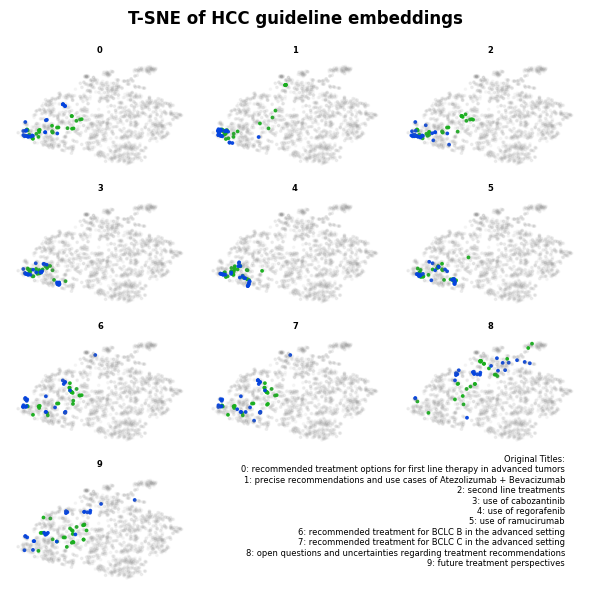

In [69]:
# HCC
hcc_queries = all_query_ids["HCC"]
n = len(hcc_queries)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axes = plt.subplots(rows, cols, figsize=(6,6))
if rows > 1 and cols > 1:
    axes = axes.flatten()


fig.suptitle("T-SNE of HCC guideline embeddings", fontsize=12, fontweight='bold')
idx_to_query = {}
for i, (ax, query) in enumerate(zip(axes, hcc_queries.items())):
    key, ids = query
    ids = ids.apply(pd.Series)
    ids.columns = ["ids", "source"]
    ids = ids.explode("ids")
    idx_to_query[i] = key
    visualize_tsne(ax, embeddings_df, data_transformed, query_name=i, query_ids=ids)


for i in range(len(hcc_queries), rows * cols):
    fig.delaxes(axes[i])

original_titles_text = "Original Titles:\n" + "\n".join([f"{i}: {query}" for i, query in idx_to_query.items()])
fig.text(0.95, 0.05, original_titles_text, fontsize=6, ha='right', va='bottom')

plt.tight_layout()
plt.show()
fig.savefig("Figures/tsne_hcc_embeddings_refactored_color.png", dpi=500) 

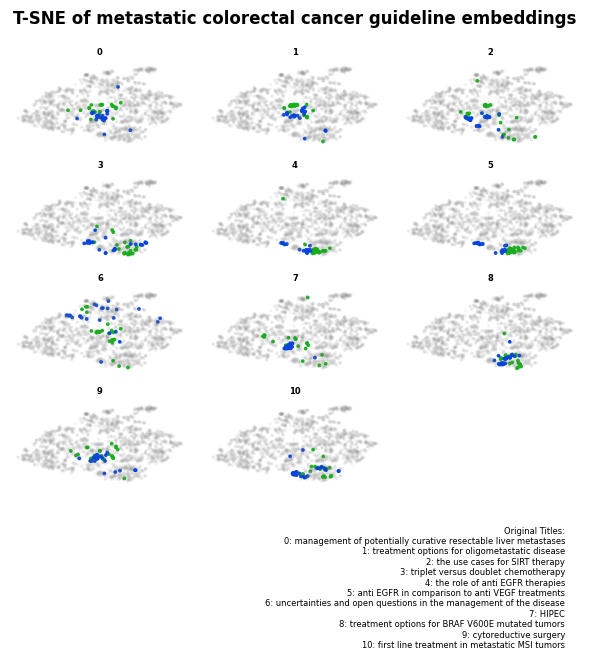

In [70]:
# mCRC
mcrc_queries = all_query_ids["mCRC"]
n = len(mcrc_queries)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))
n = len(mcrc_queries)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axes = plt.subplots(rows, cols, figsize=(6,5))
if rows > 1 and cols > 1:
    axes = axes.flatten()

fig.suptitle("T-SNE of metastatic colorectal cancer guideline embeddings", fontsize=12, fontweight='bold')
idx_to_query = {}
for i, (ax, query) in enumerate(zip(axes, mcrc_queries.items())):
    key, ids = query
    ids = ids.apply(pd.Series)
    ids.columns = ["ids", "source"]
    ids = ids.explode("ids")
    idx_to_query[i] = key
    visualize_tsne(ax, embeddings_df, data_transformed, query_name=i, query_ids=ids)

for i in range(len(mcrc_queries), rows * cols):
    fig.delaxes(axes[i])

original_titles_text = "Original Titles:\n" + "\n".join([f"{i}: {query}" for i, query in idx_to_query.items()])
# add the text directly under the figure
fig.text(0.95, -0.3, original_titles_text, fontsize=6, ha='right', va='bottom')

plt.tight_layout()
plt.show()
fig.savefig("Figures/tsne_mCRC_embeddings_refactored_color.png", dpi=500, bbox_inches='tight')

In [ ]:
# HCC
hcc_queries = all_query_ids["HCC"]
n = len(hcc_queries)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axes = plt.subplots(rows, cols, figsize=(6,6))
if rows > 1 and cols > 1:
    axes = axes.flatten()


fig.suptitle("T-SNE of HCC guideline embeddings", fontsize=12, fontweight='bold')
idx_to_query = {}
for i, (ax, query) in enumerate(zip(axes, hcc_queries.items())):
    key, ids = query
    ids = ids.apply(pd.Series)
    ids.columns = ["ids", "source"]
    ids = ids.explode("ids")
    idx_to_query[i] = key
    visualize_tsne(ax, embeddings_df, data_transformed, query_name=i, query_ids=ids)


for i in range(len(hcc_queries), rows * cols):
    fig.delaxes(axes[i])

original_titles_text = "Original Titles:\n" + "\n".join([f"{i}: {query}" for i, query in idx_to_query.items()])
fig.text(0.95, 0.05, original_titles_text, fontsize=6, ha='right', va='bottom')

plt.tight_layout()
plt.show()
fig.savefig("Figures/tsne_hcc_embeddings_refactored_color.png", dpi=500) 

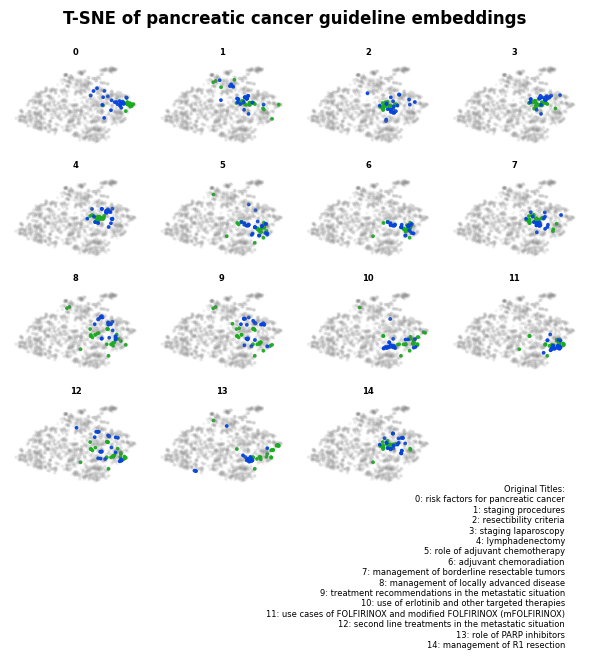

In [71]:
# pancreatic cancer
paca_queries = all_query_ids["PancreaticCancer"]
n = len(paca_queries)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axes = plt.subplots(rows, cols, figsize=(6,5))
if rows > 1 and cols > 1:
    axes = axes.flatten()

fig.suptitle("T-SNE of pancreatic cancer guideline embeddings", fontsize=12, fontweight='bold')
idx_to_query = {}
for i, (ax, query) in enumerate(zip(axes, paca_queries.items())):
    key, ids = query
    ids = ids.apply(pd.Series)  
    ids.columns = ["ids", "source"]
    ids = ids.explode("ids")
    idx_to_query[i] = key
    visualize_tsne(ax, embeddings_df, data_transformed, query_name=i, query_ids=ids)

for i in range(len(paca_queries), rows * cols):
    fig.delaxes(axes[i])

original_titles_text = "Original Titles:\n" + "\n".join([f"{i}: {query}" for i, query in idx_to_query.items()])
# add the text directly under the figure
fig.text(0.95, -0.3, original_titles_text, fontsize=6, ha='right', va='bottom')

plt.tight_layout()
plt.show()
fig.savefig("Figures/tsne_pancreaticcancer_embeddings_refactored_color.png", dpi=500, bbox_inches='tight')

In [89]:
# visualize single query

def visualize_one_tsne(embeddings_df, data_transformed, query_name, query_ids):
    fig, ax = plt.subplots(figsize=(2,1))
    transformed_df = pd.DataFrame(data_transformed, index=embeddings_df.index)
    transformed_df.rename(columns={0: "dim0", 1: "dim1"}, inplace=True)
    df = pd.merge(embeddings_df, transformed_df, left_index=True, right_index=True)
    query_ids.set_index("ids", inplace=True)
    df["sim_searched"] = df.index.to_series().map(query_ids["source"]).fillna("unused")

    def get_color(name):
        if name.startswith("ESMO"):
            return "#15B01A"
        elif name.startswith("ASCO"):
            return "#0343DF"
        else:
            return "grey"
    
    mapped_colors = [get_color(name) for name in df["sim_searched"]]

    alphas = np.where(df["sim_searched"] == "unused", 0.05, 0.9)
    scatter = ax.scatter(df.loc[:, "dim0"], df.loc[:, "dim1"], c=mapped_colors, s=3, alpha=alphas) 

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    #ax.set_title(query_name, fontweight='bold', fontsize=6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return fig

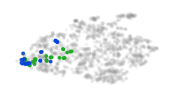

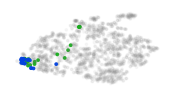

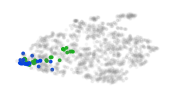

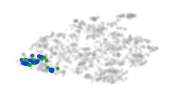

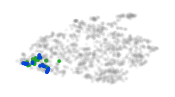

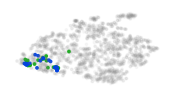

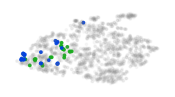

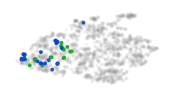

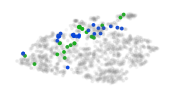

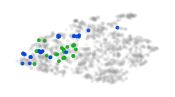

In [90]:
# HCC
hcc_queries = all_query_ids["HCC"]

for i, (key, ids) in enumerate(hcc_queries.items()):
    ids = ids.apply(pd.Series)  
    ids.columns = ["ids", "source"]
    ids = ids.explode("ids")
    idx_to_query[i] = key
    fig = visualize_one_tsne(embeddings_df, data_transformed, query_name=i, query_ids=ids)
    fig.savefig(f"Figures/tSNE/tSNE_per_query/tsne_hcc_embeddings_{key}_color.png", dpi=500)

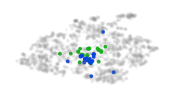

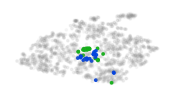

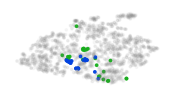

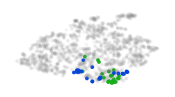

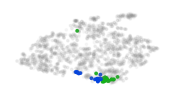

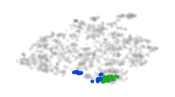

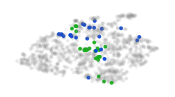

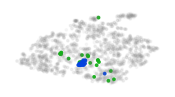

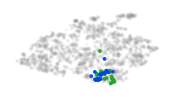

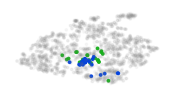

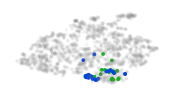

In [91]:
mcrc_queries = all_query_ids["mCRC"]

for i, (key, ids) in enumerate(mcrc_queries.items()):
    ids = ids.apply(pd.Series)  
    ids.columns = ["ids", "source"]
    ids = ids.explode("ids")
    idx_to_query[i] = key
    fig = visualize_one_tsne(embeddings_df, data_transformed, query_name=i, query_ids=ids)
    fig.savefig(f"Figures/tSNE/tSNE_per_query/tsne_mcrc_embeddings_{key}_color.png", dpi=500)

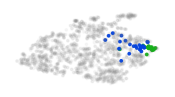

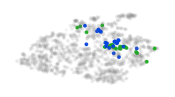

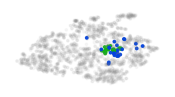

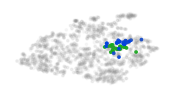

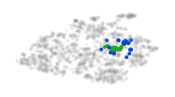

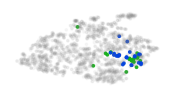

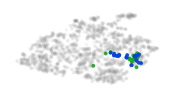

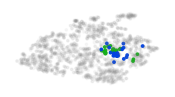

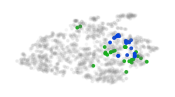

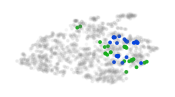

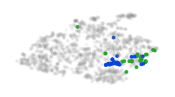

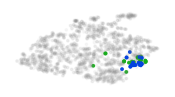

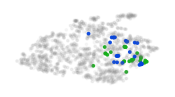

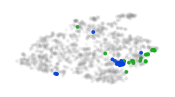

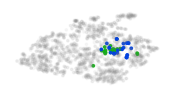

In [92]:
paca_queries = all_query_ids["PancreaticCancer"]

for i, (key, ids) in enumerate(paca_queries.items()):
    ids = ids.apply(pd.Series)  
    ids.columns = ["ids", "source"]
    ids = ids.explode("ids")
    idx_to_query[i] = key
    fig = visualize_one_tsne(embeddings_df, data_transformed, query_name=i, query_ids=ids)
    fig.savefig(f"Figures/tSNE/tSNE_per_query/tsne_pancreaticcancer_embeddings_{key}_color.png", dpi=500)